In [12]:
import geopandas as gpd
import pandas as pd
from psycopg2.pool import SimpleConnectionPool
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [13]:
gdf22 = gpd.read_file(r'C:\\Users\\User\\nuck_figgers\\work\\Fields_2022.json')
gdf22['Date'] = 2022
gdf23 = gpd.read_file(r'C:\\Users\\User\\nuck_figgers\\work\\Fields_2023.json')
gdf23['Date'] = 2023
gdf24 = gpd.read_file(r'C:\\Users\\User\\nuck_figgers\\work\\Fields_2024.json')
gdf24['Date'] = 2024
gdf = gpd.GeoDataFrame(pd.concat([gdf22, gdf23, gdf24], ignore_index=True))
gdf

KeyboardInterrupt: 

In [5]:
try:
    with open('configuration.json', 'r') as file:
        config = json.load(file)
        config['model'] = f"model_{datetime.datetime.now().isoformat()}.joblib"
    with open('configuration.json', 'w') as file:
        json.dump(config, file)
except FileNotFoundError as e:
    raise
except json.JSONDecodeError as e:
    raise
config


{'train_geojson_file': 'Fields_2024.json',
 'classify_geojson_file': 'fields2024.json',
 'new_geojson_file': 'newfields2024.json',
 'model': 'model_2024-10-19T20:12:38.977230.joblib',
 'year': 2024,
 'persecond': 20,
 'database': {'dbname': 'geoservice',
  'user': 'postgres',
  'password': 'qypTBq2aVV4',
  'host': 'localhost',
  'port': 5432}}

In [6]:
# temp = gdf24.drop(columns=['Name', 'Date'])
# temp.to_file('fields24.json', driver='GeoJSON')

In [7]:
db_config = {
    'dbname': 'geoservice',
    'user': 'postgres',
    'password': 'qypTBq2aVV4',
    'host': 'localhost',
    'port': '5432'
}

YEAR = 2024

request_string = '''SELECT "AgroFieldID", "NDVI", "Date" FROM geoservice.agrofieldndvi WHERE EXTRACT(YEAR FROM "Date") = %s;'''

In [8]:
conn_pool = SimpleConnectionPool(1, 5, **db_config)
try:
    conn = conn_pool.getconn()
    cursor = conn.cursor()
    try:
        cursor.execute(request_string, (YEAR,))
        dfSeries = pd.DataFrame(cursor.fetchall(), columns=['ID', 'NDVI', 'Date'])
        # cursor.execute("DELETE FROM geoservice.agrofieldndvi;")
    finally:
        cursor.close()
        conn_pool.putconn(conn)
except Exception as e:
    print(f"Error {e} occured")

dfSeries = dfSeries.dropna()
dfSeries

,ID,NDVI,Date


In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline

veg_start_date = datetime.date(YEAR, 4, 1).toordinal()  # c 01-04 по 01-09
veg_end_date = datetime.date(YEAR, 9, 1).toordinal()
veg_dates = [(datetime.date.fromordinal(date))
             for date in np.arange(veg_start_date, veg_end_date)]
features = []
labels = []
objIDs = []

for key in dfSeries['ID'].unique():
    X = np.array(dfSeries.loc[dfSeries['ID'] == key, 'Date']).flatten()
    Y = np.array(dfSeries.loc[dfSeries['ID'] == key, 'NDVI'])
    X_ordinals = np.array([i.toordinal() for i in X[::-1]])
    Y = np.array([i for i in Y[::-1]])

    # newX = np.arange(veg_start_date, veg_end_date)
    # newY = np.interp(newX, X_ordinals, Y)

    if Y[0] < 0:
        X_ordinals[0] = veg_start_date
        Y[0] = 0

    for i in range(1, len(Y) - 1):
        if Y[i-1] > 0 and Y[i] < 0 and Y[i+1] > 0:
            Y[i] = np.mean((Y[i-1], Y[i+1]))

    newX = np.arange(veg_end_date - veg_start_date)
    X_ordinals = X_ordinals - veg_start_date
    s = InterpolatedUnivariateSpline(X_ordinals, Y, k=1)
    newY = s(newX)

    features.append(newY)
    objIDs.append(key)
    labels.append(str(gdf.loc[(gdf['ID'] == key) & (gdf['Date'] == YEAR), 'Name'].values).translate({ord(i): None for i in '\'[]'}))

features = np.array(features, dtype="float")
labels = np.array(labels)

In [10]:
features[15, ], features.shape

IndexError: index 15 is out of bounds for axis 0 with size 0

In [9]:
labels.shape

(682,)

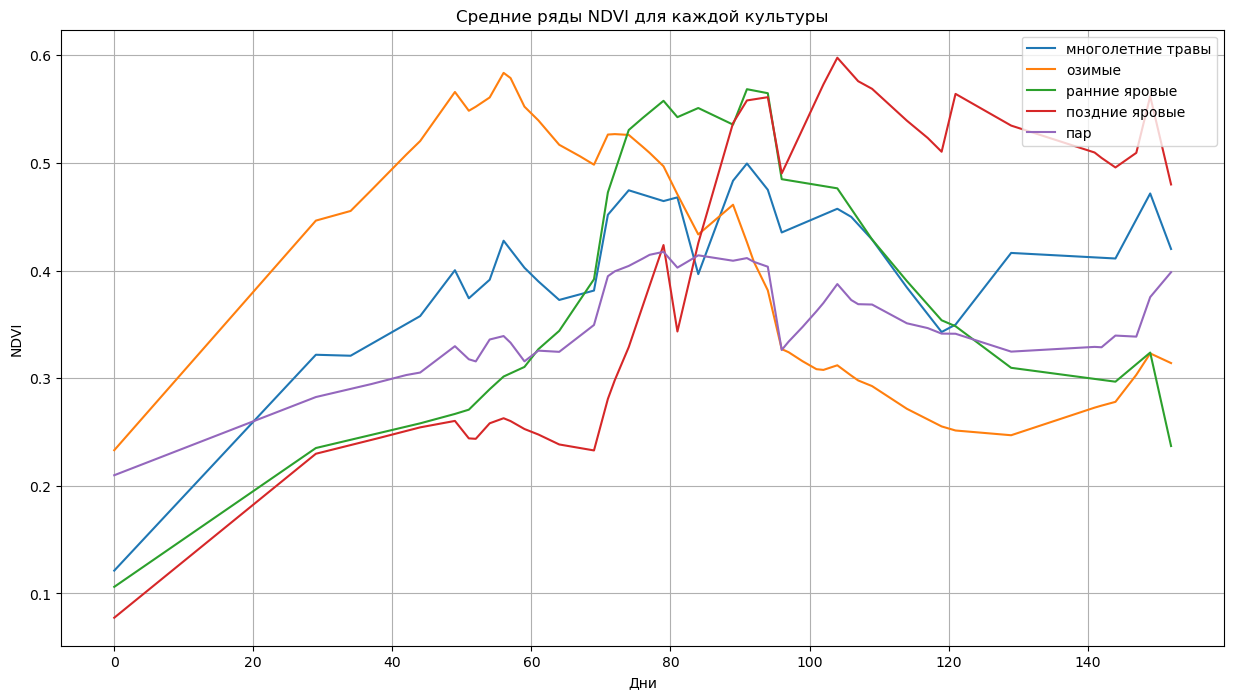

In [10]:
from collections import defaultdict

culture_ndvi = defaultdict(list)
for feature, label in zip(features, labels):
    culture_ndvi[label].append(feature)

average_ndvi = {}
for culture, ndvi_series in culture_ndvi.items():
    average_ndvi[culture] = np.mean(ndvi_series, axis=0)

plt.figure(figsize=(15, 8))
for culture, avg_ndvi in average_ndvi.items():
    plt.plot(avg_ndvi, label=culture)

plt.title('Средние ряды NDVI для каждой культуры')
plt.xlabel('Дни')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [11]:
# for i in range(0, 30):
#     plt.figure(figsize=(6, 3))
#     plt.plot(veg_dates, features[i], label='Интерполяция NDVI')
#     plt.scatter(dfSeries.loc[dfSeries['ID'] == objIDs[i], 'Date'], dfSeries.loc[dfSeries['ID']
#                 == objIDs[i], 'NDVI'], color='red', label='Исходные NDVI')
#     plt.xlabel('Дата')
#     plt.ylabel('NDVI')
#     plt.title(f'Интерполяция NDVI для ID {key}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [15]:
def create_split(random_state):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=random_state*17)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [14]:
# accuracy = []
# ins = range(10, 300, 5)
# for i in ins:
#     X_train, X_test, y_train, y_test = create_split(17)
#     gnb = RandomForestClassifier(max_depth=13, n_estimators=i)
#     model = gnb.fit(X_train, y_train)
#     preds = gnb.predict(X_test)
#     accuracy.append(accuracy_score(y_test, preds))

# indx = np.argmax(accuracy)
# print(accuracy[indx])

# plt.plot(ins, accuracy)
# plt.xlabel('Количество деревьев')
# plt.ylabel('Точность')
# plt.title('Зависимость точности от кол. деревьев при неизменной глубине деревьев')
# plt.show()

In [15]:
# accuracy = []
# ins = range(1, 30)
# for i in ins:
#     X_train, X_test, y_train, y_test = create_split(17)
#     gnb = RandomForestClassifier(max_depth=i, n_estimators=143)
#     model = gnb.fit(X_train, y_train)
#     preds = gnb.predict(X_test)
#     accuracy.append(accuracy_score(y_test, preds))

# indx = np.argmax(accuracy)
# print(accuracy[indx])

# plt.plot(ins, accuracy)
# plt.xlabel('Глубина')
# plt.ylabel('Точность')
# plt.title('Зависимость точности от глубины деревьев при неизменном кол. деревьев')
# plt.show()

In [17]:
KFold = 10

trains = []
accuracys = np.zeros((KFold, 1), dtype='float32')
label_encoder = LabelEncoder()

for i in range(KFold):
    X_train, X_test, y_train, y_test = create_split(i)
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    rfc = RandomForestClassifier(
        max_depth=13, n_estimators=143, random_state=i)
    rfc.fit(X_train, y_train_encoded)
    preds = rfc.predict(X_test)
    preds_original = label_encoder.inverse_transform(preds)
    accuracy = accuracy_score(y_test_encoded, preds)
    accuracys[i] = accuracy
    trains.append((X_train, y_train))

indx = np.argmax(accuracys)
print(accuracys, '\n')
model = rfc.fit(trains[indx][0], trains[indx][1])
print(accuracys[indx])

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [18]:
indx

48

In [30]:
import joblib
model_path = f"models/model_{datetime.datetime.now().date()}_{datetime.datetime.now().toordinal()}.joblib"
# joblib.dump(model, model_path, compress=9)
# model1 = joblib.load(model_path)
# _, _, xt, yt = create_split(3)
# pred = model1.predict(xt)
# accuracy_score(yt, pred)
model_path

'models/model_2024-10-19_739178.joblib'